In [247]:
import pandas as pd
import numpy as np
import sqlite3
import json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mode

# Thanks StackOverflow!
# https://stackoverflow.com/questions/21137150/format-suppress-scientific-
#         notation-from-python-pandas-aggregation-results
pd.options.display.float_format = '{:.2f}'.format

In [248]:
cd '/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/analysis'

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/analysis


In [249]:
conn = sqlite3.connect('movie_analysis2.db')
cur = conn.cursor()

In [250]:
# Source: https://pbpython.com/effective-matplotlib.html

# {:1.1f} in this case means: apply format to the first 1 instance
# that value should be presented with .1f = as a float with 1 point precision
# change the second number to increase or decrease precision

def currency(x, pos):
    'The two args are the value and tick position'
    if abs(x) >= 1000000000:
        return '${:1.1f} B'.format(x*1e-9)
        return '${:1.1f} B'.format(x*1e-9)
    elif abs(x) >= 1000000:
        return '${:1.1f} M'.format(x*1e-6)
    elif x == 0:
        return '${:0}'.format(x)
    else:
        return '${:1.0f} K'.format(x*1e-3)
    
def currency_num(x):
    if abs(x) >= 1000000000:
        return '${:1.1f} B'.format(x*1e-9)
        return '${:1.1f} B'.format(x*1e-9)
    elif abs(x) >= 1000000:
        return '${:1.1f} M'.format(x*1e-6)
    elif x == 0:
        return '${:0}'.format(x)
    else:
        return '${:1.0f} K'.format(x*1e-3)

# Topic 1: Profitability Trends

## Create dataframe with relevant films for financial analysis

In [251]:
# Updated query with already-filtered movies

sql = """SELECT DISTINCT m.id
                        , m.budget
                        , m.revenue
                        , m.release_date
                        , m.original_language
                        , m.imdb_id
                        , m.runtime
                        , m.vote_average
                        , m.vote_count
         FROM tmdb_movies m
         """

df = pd.DataFrame(cur.execute(sql).fetchall(),columns=[x[0] for x in cur.description])

In [252]:
# check column types and counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495 entries, 0 to 6494
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6495 non-null   int64  
 1   budget             6495 non-null   int64  
 2   revenue            6495 non-null   int64  
 3   release_date       6495 non-null   object 
 4   original_language  6495 non-null   object 
 5   imdb_id            6339 non-null   object 
 6   runtime            6466 non-null   float64
 7   vote_average       6495 non-null   float64
 8   vote_count         6495 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 456.8+ KB


In [253]:
# check the min, max values for numerical columns
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,6495.00,6495.00,6495.00,6466.00,6495.00,6495.00
mean,258486.24,13276910.31,40985169.36,90.76,5.38,853.54
std,181000.75,35218833.96,145958457.22,37.24,2.29,2253.10
min,189.00,0.00,0.00,0.00,0.00,0.00
25%,95784.50,0.00,0.00,84.00,4.90,4.00
50%,234200.00,0.00,0.00,94.00,6.00,52.00
75%,366652.50,7000000.00,5221955.50,107.00,6.80,494.00
max,806779.00,380000000.00,2797800564.00,1200.00,10.00,28633.00


We definitely have some movies where budget or revenue is missing, or one or the other are really low and probably not accurate.
Let's drop rows from the table where the budget and revenue data doesn't look usable.

Will use a cut off limit of \\$10,000; both budget and revenue must be over \\$10,000


- https://www.themoviedb.org/movie/599290-wwr-tournament-for-tomorrow is a good example
- https://www.themoviedb.org/movie/254191-honeymoon another example

In [254]:
# Export to CSV to review before dropping. Everything here looks wonky.
df.loc[(df['budget'] < 10000) | (df['revenue'] < 10000),['budget','revenue']
      ].to_csv('budget_revenue_double-check.csv')

In [255]:
# Drop the rows where either budget or revennue is less than 10k
to_drop = df[(df['budget'] < 10000) | (df['revenue'] < 10000)].index
df.drop(labels=to_drop, axis=0, inplace=True)


In [256]:
# 4708 records dropped, and 1787 remain
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1787 entries, 1 to 6352
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1787 non-null   int64  
 1   budget             1787 non-null   int64  
 2   revenue            1787 non-null   int64  
 3   release_date       1787 non-null   object 
 4   original_language  1787 non-null   object 
 5   imdb_id            1787 non-null   object 
 6   runtime            1787 non-null   float64
 7   vote_average       1787 non-null   float64
 8   vote_count         1787 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 139.6+ KB


In [257]:
# min budget and revenues look better
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,1787.00,1787.00,1787.00,1787.00,1787.00,1787.00
mean,215170.33,45439992.95,146682340.17,109.65,6.43,2820.37
std,153536.11,54139850.31,248665399.57,18.02,0.87,3592.97
min,189.00,17000.00,11400.00,0.00,0.00,0.00
25%,70781.50,10000000.00,12638911.50,97.00,5.90,542.50
50%,195589.00,25000000.00,52545707.00,107.00,6.40,1488.00
75%,334528.50,57500000.00,160367082.50,120.00,7.00,3595.50
max,768710.00,380000000.00,2797800564.00,188.00,8.50,28633.00


In [258]:
# But runtime has a min of 0. Let's replace with NaN so they won't be calculated
df.loc[df['runtime'] == 0, 'runtime'] = np.nan

In [259]:
# Now there should be no 0 min for runtime
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,1787.00,1787.00,1787.00,1785.00,1787.00,1787.00
mean,215170.33,45439992.95,146682340.17,109.78,6.43,2820.37
std,153536.11,54139850.31,248665399.57,17.65,0.87,3592.97
min,189.00,17000.00,11400.00,63.00,0.00,0.00
25%,70781.50,10000000.00,12638911.50,97.00,5.90,542.50
50%,195589.00,25000000.00,52545707.00,107.00,6.40,1488.00
75%,334528.50,57500000.00,160367082.50,120.00,7.00,3595.50
max,768710.00,380000000.00,2797800564.00,188.00,8.50,28633.00


In [260]:
# Looks like all of our films have release dates (string len 10)
# This makes sense, since we filtered the original set of movie ids
# based on release dates 2010 and on
df['release_date'].map(lambda x: len(x)).value_counts()

10    1787
Name: release_date, dtype: int64

In [261]:
# Split out year and month into new df columns
month_map = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
             7:'July',8:'August',9:'September',10:'October',11:'November',
             12:'December'}

df['release_year'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: int(x[:4]))
df['release_month'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: month_map[int(x[5:7])])

# Would need to use the below if there were null release dates, but there aren't
#df.loc[df['release_year'].isna()==True, 'release_year'] = 0
#df['release_year'] = df['release_year'].astype(int)

In [262]:
# add a numerical month column, to make sorting easier
rev_month_map = {}
for k, v in month_map.items():
    rev_month_map[v] = k
    
rev_month_map

df['release_month_num'] = df['release_month'].map(lambda x: rev_month_map[x])


In [263]:
df.head()

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,release_month_num
1,587807,50000000,100000000,2021-02-11,en,tt1361336,101.00,7.60,844,2021,February,2
2,458576,60000000,25814306,2020-12-03,en,tt6475714,104.00,7.20,1136,2020,December,12
3,464052,200000000,159533000,2020-12-16,en,tt7126948,151.00,6.90,4271,2020,December,12
4,602269,30000000,23205000,2021-01-28,en,tt10016180,128.00,6.50,578,2021,January,1
7,529203,65000000,135076090,2020-11-25,en,tt2850386,95.00,7.50,1733,2020,November,11


Looks like I have movies that were released this year, in 2021. These results are incomplete since we're still in 2021, so I will drop those years from this dataset for now. 

In [264]:
# Drop the rows where either budget or revennue is less than 10k
to_drop = df[df['release_year'] == 2021].index
df.drop(labels=to_drop, axis=0, inplace=True)

In [265]:
# Check to see they were all dropped out, this should return nothing
df[df['release_year'] == 2021]

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,release_month_num


Before calculating profitability, want to adjust the numbers for inflation. Retrieved the Consumer Price Index from http://www.bls.gov/ using the instructions here: https://www.maa.org/press/periodicals/loci/joma/the-consumer-price-index-and-inflation-get-cpi-data-from-the-web-and-into-a-spreadsheet

Will make the assumption that the vast majority of the revenue happened in the release year. This assumption is based on the revenue being box office only, and typically most movies only play in theaters for a few months. The one caveat is that revenue is worlwide, and releases in other countries may have been somewhat later.

In [266]:
cd '/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data'

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data


In [267]:
# Read in Consumer Price Index info from CSV
df_cpi = pd.read_csv('Consumer Price Index.csv')

cpi_dict = pd.Series(df_cpi['Annual'].values,index=df_cpi['Year']).to_dict()

In [268]:
# Adjust budget for inflation
df['budget_2020adj'] = df[(df['budget'].isna()==False) & (df['budget'] > 0)
       ][['budget', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]], axis=1)


In [269]:
# Adjust revenue for inflation
df['revenue_2020adj'] = df[(df['revenue'].isna()==False) & (df['revenue'] > 0)
       ][['revenue', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]]
                                           , axis=1)

In [270]:
# Calculate profit with inflation-adjusted values
# Only calculate where have both sets of values
df['profit_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(lambda x : (x[0] - x[1]), axis=1)

In [271]:
# Calculate % profit with inflation-adjusted values
df['profitpercent_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(
    lambda x : ((x[0] - x[1]) / x[1]) * 100, axis=1)

In [272]:
# Hmm, so we have instances of profit being negative almost 100%, but not 
# quite -100%. This is important, since a profit of -100% would mean made $0
# or very little in revenue, and we were supposed to have removed the small values.

# Mean profit percentage is 327%
df['profitpercent_2020adj'].describe()

count    1784.00
mean      327.96
std      1399.87
min       -99.91
25%        -5.08
50%       121.34
75%       323.79
max     42564.41
Name: profitpercent_2020adj, dtype: float64

In [273]:
# And median profit percentage is 121%, which means doubled money + 20%
df['profitpercent_2020adj'].median()

121.34331755102039

In [274]:
df[df['profitpercent_2020adj'] < 0]['profitpercent_2020adj'].sort_values()

2367   -99.91
2484   -99.91
3021   -99.89
4036   -99.87
4519   -99.86
        ...  
468     -0.93
1459    -0.39
665     -0.37
2733    -0.30
714     -0.04
Name: profitpercent_2020adj, Length: 468, dtype: float64

Looks like we have a pretty good size sample of movies for each year. 2019 is smaller and 2020 even smaller than that. It could be there were truly fewer movies released to theaters in 2020 due to COVID-19, and could also be that it takes a while for users to enter revenues and budgets, and that 

In [275]:
# How many movies do we have in our sample for each year?
df['release_year'].value_counts(sort=False)

2010    201
2011    209
2012    175
2013    204
2014    198
2015    175
2016    195
2017    145
2018    147
2019    110
2020     25
Name: release_year, dtype: int64

In [276]:
df.loc[df['profitpercent_2020adj'] <= -5]

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,release_month_num,budget_2020adj,revenue_2020adj,profit_2020adj,profitpercent_2020adj
2,458576,60000000,25814306,2020-12-03,en,tt6475714,104.00,7.20,1136,2020,December,12,60000000.00,25814306.00,-34185694.00,-56.98
3,464052,200000000,159533000,2020-12-16,en,tt7126948,151.00,6.90,4271,2020,December,12,200000000.00,159533000.00,-40467000.00,-20.23
21,338762,42000000,33542457,2020-03-05,en,tt1634106,110.00,6.90,3654,2020,March,3,42000000.00,33542457.00,-8457543.00,-20.14
25,443791,80000000,40882928,2020-01-08,en,tt5774060,95.00,6.30,1963,2020,January,1,80000000.00,40882928.00,-39117072.00,-48.90
28,340102,67000000,45534613,2020-08-26,en,tt4682266,94.00,6.40,1656,2020,August,8,67000000.00,45534613.00,-21465387.00,-32.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5621,372994,1500000,40840,2015-11-26,ru,,93.00,6.00,2,2015,November,11,1637926.82,44595.29,-1593331.53,-97.28
5666,479750,1200000,806000,2017-01-01,mn,tt5858514,101.00,0.00,0,2017,January,1,1267025.13,851018.55,-416006.58,-32.83
5864,116741,58000000,44000000,2013-06-07,en,tt2234155,119.00,6.20,3265,2013,June,6,64436947.59,48883201.62,-15553745.97,-24.14
6017,692005,20000,11400,2020-03-20,bn,tt10122618,112.00,0.00,0,2020,March,3,20000.00,11400.00,-8600.00,-43.00


In [277]:
# OK so we don't have any outliers on the lower end, but we definitely do on the upper end.
# I'm going to separate into
# less than 0 (lost money)
# 0-200% profit
# 200-400% profit
# 400-600% profit
# 600-817% profit
# everything above 817%, which are outliers

q1 = df['profitpercent_2020adj'].quantile(.25)
q3 = df['profitpercent_2020adj'].quantile(.75)
iqr = q3-q1

lower_outlier_bound = q1-(iqr*1.5)
upper_outlier_bound = q3+(iqr*1.5)

display(lower_outlier_bound, upper_outlier_bound)

-498.3892067548078

817.1045955913463

In [278]:
# Create % profit categories, updated version
# over 817% would be considered outliers
# everything below 0 is a loww
# amounts between 0 and outlier territory are split about equally into 4 bins
df.loc[df['profitpercent_2020adj'] < 0, 'profit_category'] = 'Loss'
df.loc[(df['profitpercent_2020adj'] >= 0) & (
    df['profitpercent_2020adj'] <= 200), 'profit_category'] = '0 - 200% ROI'
df.loc[(df['profitpercent_2020adj'] > 200) & (
    df['profitpercent_2020adj'] <= 400), 'profit_category'] = '200 - 400% ROI'
df.loc[(df['profitpercent_2020adj'] > 400) & (
    df['profitpercent_2020adj'] <= 600), 'profit_category'] = '400 - 600% ROI'
df.loc[(df['profitpercent_2020adj'] > 600) & (
    df['profitpercent_2020adj'] <= 800), 'profit_category'] = '600 - 800% ROI'
df.loc[df['profitpercent_2020adj'] > 800, 'profit_category'] = 'Over 800% ROI'


In [279]:
q10_labels = ['0-10Q','10-20Q','20-30Q', '30-40Q', '40-50Q', '50-60Q', '60-70Q', 
 '70-80Q', '80-90Q', '90-100Q']

df['roi_quantile'] = pd.qcut(df['profitpercent_2020adj'], 10, labels=q10_labels)

In [280]:
q_dict = df['profitpercent_2020adj'].quantile(
    [.1, .2, .3, .4, .5, .6, .7, .8, .9]).to_dict()

q_dict

{0.1: -73.9285389,
 0.2: -29.225862299999996,
 0.3: 14.338303594827584,
 0.4: 67.53415040000002,
 0.5: 121.34331755102039,
 0.6: 180.05408226666668,
 0.7: 266.69705647222224,
 0.8: 390.9955402727274,
 0.9: 678.4591498478262}

<AxesSubplot:xlabel='profitpercent_2020adj', ylabel='Count'>

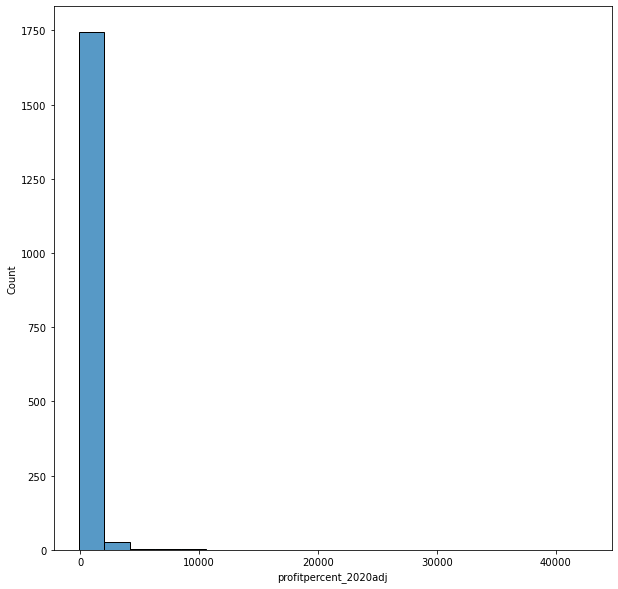

In [281]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(df['profitpercent_2020adj'], bins=20)

## Box Office Profit per Release Year

In [282]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

### 2020 not withstanding, people DO still go to the movies.

The graph below shows median profit (box office revenue less production budget) for the last 10 years. Amounts are in 2020 US dollars, after adjustment for inflation.

The median profit for films released in 2020 is actually negative. We calculated profit using only box office revenue, and movie theaters were closed for most of 2020 due to the COVID-19 pandemic.

The 2020 results have been left as strong evidence that the data we're using to perform this analysis is representative enough to show trends. While the median profit certainly hasn't increased steadily (2013, 2016, and 2018 had some dips),  profits are generally increasing over time. 

Before the COVID-19 pandemic, box office revenues were healthy, even as original titles produced by companies--such as Amazon, Netflix and Hulu--were released directly to subscribers, bypassing theaters entirely.  



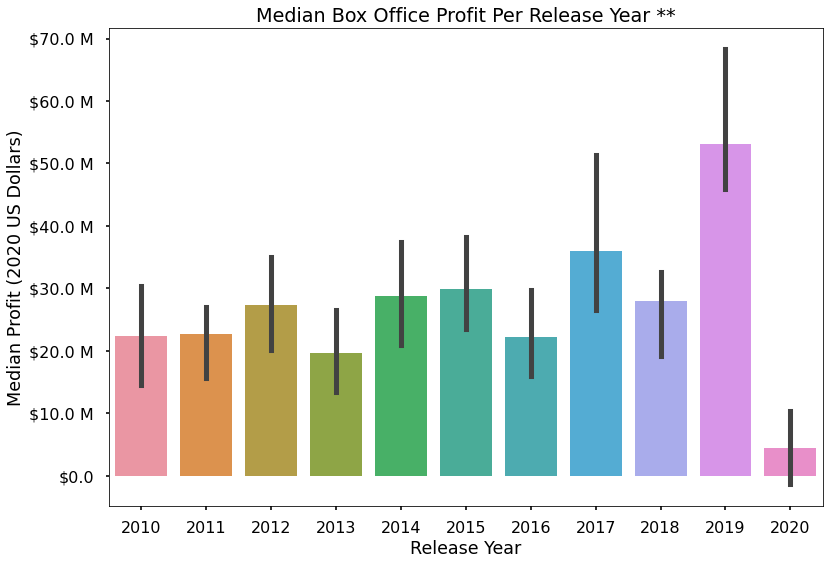

In [283]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()

    sns.barplot(x=df['release_year'], y=df['profit_2020adj']
                , estimator=np.median, ax=ax, ci=68)

    ax.set_title('Median Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Median Profit (2020 US Dollars)');
    
    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))

### Many of the most profitable movies are outliers

Per the previous chart and below, median profit fell within a range of \\$20 MM to \\$35 MM 2020 US dollars for the past 10 years. Even the average was only around \\$100 MM.

But when we look at the distributions within each year, we see that there are many values well above that, in the many hundreds of millions, or billions of dollars. However, these are statistical outliers.

This means that while it's certainly possible to make hundreds of millions or billions of dollars at the box office on a film, that isn't a common outcome.

In [284]:
# Median across across all years in millions
df['profit_2020adj'].quantile(0.5)/1000000

27.30874951389894

In [285]:
# median profits per year
df_yr_medprofit = df.groupby('release_year')['profit_2020adj'].median().reset_index()
df_yr_medprofit['profit_2020adj'] = df_yr_medprofit['profit_2020adj'
                                                   ].map(lambda x : currency_num(x))

df_yr_medprofit.rename(columns={'profit_2020adj': 'Median Profit', 
                                'release_year': 'Year Released'})

,Year Released,Median Profit
0,2010,$22.3 M
1,2011,$22.6 M
2,2012,$27.4 M
3,2013,$19.6 M
4,2014,$28.7 M
5,2015,$29.9 M
6,2016,$22.3 M
7,2017,$35.9 M
8,2018,$27.9 M
9,2019,$53.1 M


In [286]:
# overall mean profit in millions
df['profit_2020adj'].mean()/1000000

110.42956220650537

In [287]:
# mean profit per year
df_yr_meanprofit = df.groupby('release_year')['profit_2020adj'].mean().reset_index()
df_yr_meanprofit['profit_2020adj'] = df_yr_meanprofit['profit_2020adj'
                                                   ].map(lambda x : currency_num(x))

df_yr_meanprofit.rename(columns={'profit_2020adj': 'Mean Profit', 
                                'release_year': 'Year Released'})

,Year Released,Mean Profit
0,2010,$86.7 M
1,2011,$86.9 M
2,2012,$111.1 M
3,2013,$92.0 M
4,2014,$99.4 M
5,2015,$119.7 M
6,2016,$107.4 M
7,2017,$147.3 M
8,2018,$132.6 M
9,2019,$180.1 M


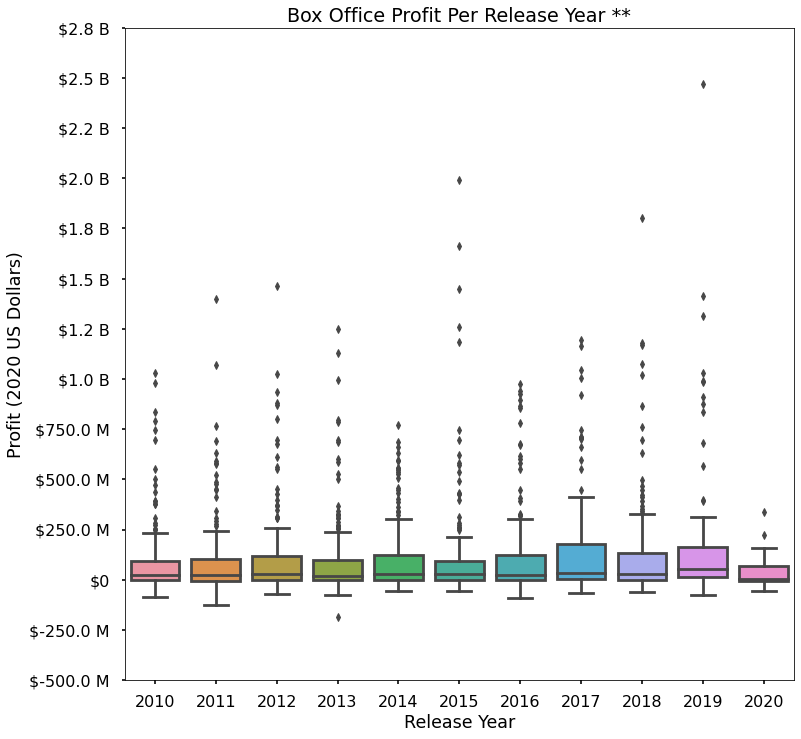

In [288]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['profit_2020adj']
                , ax=ax)
    # Source: https://pbpython.com/effective-matplotlib.html
    #ax.axhline(y=avg, color='b', label='Average', linestyle='--', linewidth=3)
#    sns.swarmplot(x=df_recent['release_year'], y=df_recent['profit_2020adj']
#                , ax=ax, size=1.5, color='black')

    ax.set_title('Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-500000000, 3000000000, 250000000));

NameError: name 'df_recent' is not defined

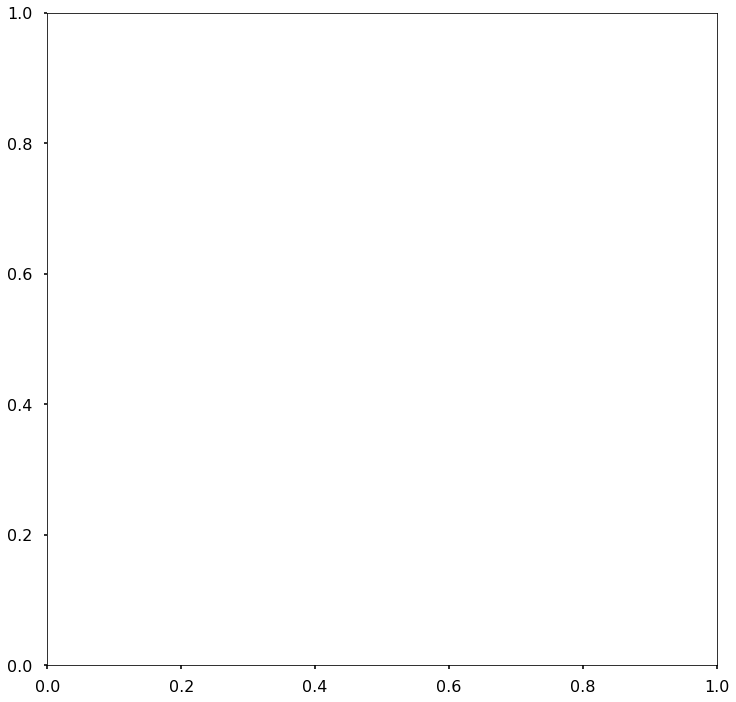

In [289]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    avg = df_recent['profit_2020adj'].mean()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df['release_year'], y=df['profit_2020adj']
                , ax=ax, showfliers=False)

    ax.set_title('Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-200000000, 400000000, 50000000))


In [ ]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.histplot(df['profit_2020adj'], ax=ax, bins=30)
    ax.set_title('Box Office Profit Distribution');
    ax.set_xlabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))

In [ ]:
df['profit_category'].unique()

In [ ]:
profit_category_order = ['Loss', '0 - 200% ROI', '200 - 400% ROI', 
        '400 - 600% ROI', '600 - 800% ROI', 'Over 800% ROI']

with plt.style.context('seaborn-notebook'):
    plt.tight_layout();
    fig, ([ax1, ax2]) = plt.subplots(figsize=(8, 10), ncols=1, nrows=2);

    sns.scatterplot(x=df['budget_2020adj'], y=df['profit_2020adj']
                    , ax=ax1, hue=df['profit_category'],
                   hue_order=profit_category_order);
          
    sns.scatterplot(x=df['budget_2020adj'], y=df['profit_2020adj']
                    , ax=ax2, hue=df['profit_category'],
                   hue_order=profit_category_order,
                   palette='coolwarm');
    
    #ax1.set_title('Production Budget versus Box Office Profit (2020 US Dollars)');
    ax1.set_xlabel('Production Budget');
    ax1.set_ylabel('Box Office Profit');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(currency));
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(currency));

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(df['profit_category'], )

In [ ]:
profit_category_order = q10_labels

with plt.style.context('seaborn-notebook'):
    plt.tight_layout();
    fig, ([ax1, ax2]) = plt.subplots(figsize=(8, 10), ncols=1, nrows=2);

    sns.scatterplot(x=df['budget_2020adj'], y=df['profit_2020adj']
                    , ax=ax1, hue=df['roi_quantile'],
                   hue_order=profit_category_order);
          
    sns.scatterplot(x=df['budget_2020adj'], y=df['profit_2020adj']
                    , ax=ax2, hue=df['roi_quantile'],
                   hue_order=profit_category_order,
                   palette='coolwarm');
    
    #ax1.set_title('Production Budget versus Box Office Profit (2020 US Dollars)');
    ax1.set_xlabel('Production Budget');
    ax1.set_ylabel('Box Office Profit');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(currency));
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(currency));

# Topic 2: Characteristics of Profitable Movies

Are the more profitable movies released in a certain month?

December has the highest median profit for movies released in that month. This isn't surprising, given many movies seem to be released in December to catch the holiday season in the US. 

It would be a good idea to plan for movies to be released in December to maximize profitability, and November, May, June, and July are also good choices.

Interestingly, September is the month with the most number of movies released, and it also has the lowest median profit. I would not recommend releasing movies in September, if you can avoid it.



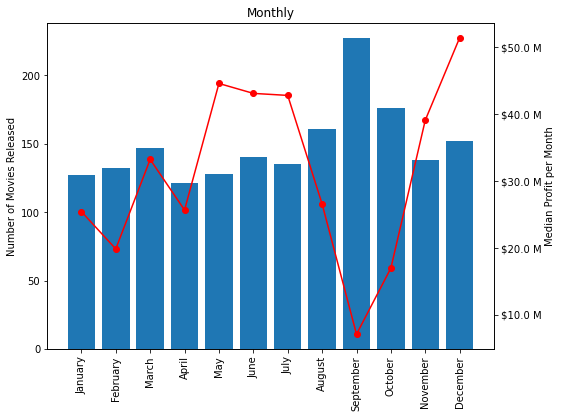

In [291]:
month_order = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']

# Source: https://stackoverflow.com/questions/12589481/multiple-aggregations-
# of-the-same-column-using-pandas-groupby-agg
profit_by_month = df.groupby('release_month_num').agg(
    Median=('profit_2020adj', 'median'), 
    Count=('profit_2020adj', 'count'))

profit_by_month

fig, ax = plt.subplots(figsize=(8, 6))
ax2=ax.twinx()
# Source: James Irving
ax2.plot(profit_by_month.index,profit_by_month.Median,marker='o',c='r')
ax.bar(profit_by_month.index, profit_by_month.Count, )

# set and format labels
ax.set_ylabel('Number of Movies Released');
ax2.set_ylabel('Median Profit per Month');
ax.set_title('Monthly')

ax.set_xticks(list(month_map.keys()));
ax.set_xticklabels(list(month_map.values()), rotation=90);
ax2.yaxis.set_major_formatter(plt.FuncFormatter(currency));

Let's look at genres, what are the most popular genres?

In [292]:
sql2 = """SELECT mg.genre_id, g.genre, 
                 m.id, m.title
          FROM tmdb_movies m
          INNER JOIN tmdb_movie_genres mg ON mg.id = m.id
          INNER JOIN tmdb_genres g ON mg.genre_id = g.genre_id
         """

dfg = pd.DataFrame(cur.execute(sql2).fetchall(),columns=[x[0] for x in cur.description])

In [293]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13275 entries, 0 to 13274
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genre_id  13275 non-null  int64 
 1   genre     13275 non-null  object
 2   id        13275 non-null  int64 
 3   title     13275 non-null  object
dtypes: int64(2), object(2)
memory usage: 415.0+ KB


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 2 to 6352
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1784 non-null   int64   
 1   budget                 1784 non-null   int64   
 2   revenue                1784 non-null   int64   
 3   release_date           1784 non-null   object  
 4   original_language      1784 non-null   object  
 5   imdb_id                1784 non-null   object  
 6   runtime                1782 non-null   float64 
 7   vote_average           1784 non-null   float64 
 8   vote_count             1784 non-null   int64   
 9   release_year           1784 non-null   int64   
 10  release_month          1784 non-null   object  
 11  release_month_num      1784 non-null   int64   
 12  budget_2020adj         1784 non-null   float64 
 13  revenue_2020adj        1784 non-null   float64 
 14  profit_2020adj         1784 non-null   f

In [295]:
# Merge the calculated values from our movies dataframe into the genres one
df_genres= dfg.merge(df[['id','profit_2020adj', 
                         'profitpercent_2020adj',
                         'release_month_num']], on='id')

df_genres.head()

,genre_id,genre,id,title,profit_2020adj,profitpercent_2020adj,release_month_num
0,14,Fantasy,458576,Monster Hunter,-34185694.00,-56.98,12
1,28,Action,458576,Monster Hunter,-34185694.00,-56.98,12
2,12,Adventure,458576,Monster Hunter,-34185694.00,-56.98,12
3,14,Fantasy,464052,Wonder Woman 1984,-40467000.00,-20.23,12
4,28,Action,464052,Wonder Woman 1984,-40467000.00,-20.23,12


In [296]:
# Create a pivot table showing aggregate profits, grouped by genre
df_gp = pd.pivot_table(data=df_genres, index='genre', 
                       aggfunc={'id': 'count',
                                'profit_2020adj': [np.sum, np.mean],
                                'profitpercent_2020adj': np.median} )

In [297]:
# Movies with an Adventure genre have generated the most profit in the
# last 10 years, with Action, Comedy, and Science Fiction coming next.

df_gp['profit_2020adj', 'sum'].sort_values(ascending=False)

genre
Adventure         105181569279.50
Action             95042035330.68
Comedy             63432848352.66
Science Fiction    54735903036.87
Drama              48372933371.79
Fantasy            48293814953.30
Family             46393785802.48
Animation          36572990626.54
Thriller           36476000617.55
Romance            17355702059.32
Crime              15846196440.22
Horror             14409552899.32
Mystery             8947632621.08
Music               6532889170.20
History             5032431714.75
War                 3021754920.53
Western             1187302718.26
Documentary          398559236.01
TV Movie              -3193263.61
Name: (profit_2020adj, sum), dtype: float64

In [298]:
# Movies with an Adventure genre win for mean profit per movie.
# SciFi comes next, with Animation, Fantasy, and Family next.
# Action is 6th.

df_gp['profit_2020adj', 'mean'].sort_values(ascending=False)

genre
Adventure         278996204.99
Science Fiction   253406958.50
Animation         248795854.60
Fantasy           226731525.60
Family            210880844.56
Action            183833724.04
Music             125632484.04
Comedy            104847683.23
Thriller           74899385.25
Romance            68329535.67
Horror             65201596.83
Crime              63132256.73
Mystery            63011497.33
Western            59365135.91
War                59250096.48
Drama              58919529.08
History            47927921.09
Documentary        20976801.90
TV Movie           -3193263.61
Name: (profit_2020adj, mean), dtype: float64

In [299]:
# Documentaries have the highest ROI, followed by Horror and Animation.
# This kinda makes sense because documentaries will tend to have lower budgets 
# than big action or even animation films, so the ROI on a modest investment
# multiples more quickly.
# note that the genres that made the most profits hover around 125% to 144% ROI
# range. This is likely because they have higher budgets.

df_gp['profitpercent_2020adj', 'median'].sort_values(ascending=False)

genre
Documentary       399.67
Horror            206.58
Animation         173.24
Comedy            149.57
Family            149.15
Science Fiction   144.84
Adventure         144.25
Fantasy           137.32
Action            125.85
Music             120.86
Mystery           111.39
Romance           110.58
Thriller           82.98
Drama              82.29
Crime              70.50
Western            43.83
History            43.64
War                25.64
TV Movie          -67.26
Name: (profitpercent_2020adj, median), dtype: float64

# Topic 3: Impact of Contributors on Profitability

In [ ]:
sql3 = """SELECT w.tconst, n.primary_name, n.birth_year, 'Writer' AS role
          FROM imdb_writers w
          LEFT JOIN imdb_names n ON w.nconst = n.nconst
"""


df_writers = pd.DataFrame(cur.execute(sql3).fetchall(),columns=[x[0] for x in cur.description])
df_writers.head()

In [ ]:
sql4 = """SELECT d.tconst, n.primary_name, n.birth_year, 'Director' AS role
          FROM imdb_directors d
          LEFT JOIN imdb_names n ON d.nconst = n.nconst
"""


df_dirs = pd.DataFrame(cur.execute(sql4).fetchall(),columns=[x[0] for x in cur.description])
df_dirs.head()

In [ ]:
sql5 = """SELECT p.tconst, n.primary_name, n.birth_year, p.category AS role
          FROM imdb_principals p
          LEFT JOIN imdb_names n ON n.nconst = p.nconst
          WHERE p.category IN ('actor', 'actress')
"""


df_prins = pd.DataFrame(cur.execute(sql5).fetchall(),columns=[x[0] for x in cur.description])
df_prins.head()

In [229]:
sql6 = """SELECT r.tconst, r.averagerating, r.numvotes
          FROM imdb_ratings r
"""


df_imdbratings = pd.DataFrame(cur.execute(sql6).fetchall(),columns=[x[0] for x in cur.description])
df_imdbratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


In [230]:
display(len(df_writers), len(df_dirs), len(df_prins))

178352

163535

402893

In [231]:
df_roles = pd.concat([df_writers, df_dirs, df_prins])

len(df_roles)

744780

In [232]:
# Normalize roles to title case
df_roles['role'] = df_roles['role'].map(lambda x: x.title())

In [233]:
df_roles['role'].unique()

array(['Writer', 'Director', 'Actor', 'Actress'], dtype=object)

In [238]:
df_roles.rename(columns={'tconst': 'imdb_id'}, inplace=True)
df_imdbratings.rename(columns={'tconst': 'imdb_id'}, inplace=True)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 2 to 6352
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1784 non-null   int64   
 1   budget                 1784 non-null   int64   
 2   revenue                1784 non-null   int64   
 3   release_date           1784 non-null   object  
 4   original_language      1784 non-null   object  
 5   imdb_id                1784 non-null   object  
 6   runtime                1782 non-null   float64 
 7   vote_average           1784 non-null   float64 
 8   vote_count             1784 non-null   int64   
 9   release_year           1784 non-null   int64   
 10  release_month          1784 non-null   object  
 11  release_month_num      1784 non-null   int64   
 12  budget_2020adj         1784 non-null   float64 
 13  revenue_2020adj        1784 non-null   float64 
 14  profit_2020adj         1784 non-null   f

In [240]:
# Merge the imdb ratings and numvotes into tmdb movie working dataframe
df = df.merge(df_imdbratings[['imdb_id','averagerating', 'numvotes']], 
              how='left', on='imdb_id')

In [241]:
# and rename to reflect the provenance
df.rename(columns={'averagerating': 'imdb_averagerating', 
                   'numvotes': 'imdb_numvotes'}, inplace=True)

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 0 to 1783
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1784 non-null   int64   
 1   budget                 1784 non-null   int64   
 2   revenue                1784 non-null   int64   
 3   release_date           1784 non-null   object  
 4   original_language      1784 non-null   object  
 5   imdb_id                1784 non-null   object  
 6   runtime                1782 non-null   float64 
 7   vote_average           1784 non-null   float64 
 8   vote_count             1784 non-null   int64   
 9   release_year           1784 non-null   int64   
 10  release_month          1784 non-null   object  
 11  release_month_num      1784 non-null   int64   
 12  budget_2020adj         1784 non-null   float64 
 13  revenue_2020adj        1784 non-null   float64 
 14  profit_2020adj         1784 non-null   f

In [243]:
df_roles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744780 entries, 0 to 402892
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   imdb_id       744780 non-null  object 
 1   primary_name  744535 non-null  object 
 2   birth_year    199944 non-null  float64
 3   role          744780 non-null  object 
dtypes: float64(1), object(3)
memory usage: 28.4+ MB


In [245]:
# Merge the values from our movies dataframe into the roles one
df_credits = df_roles.merge(df[['imdb_id', 'id','profit_2020adj', 'profitpercent_2020adj',
                                'imdb_averagerating', 'imdb_numvotes']], 
                            on='imdb_id')

df_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13751 entries, 0 to 13750
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                13751 non-null  object 
 1   primary_name           13751 non-null  object 
 2   birth_year             10366 non-null  float64
 3   role                   13751 non-null  object 
 4   id                     13751 non-null  int64  
 5   profit_2020adj         13751 non-null  float64
 6   profitpercent_2020adj  13751 non-null  float64
 7   imdb_averagerating     13144 non-null  float64
 8   imdb_numvotes          13144 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.0+ MB


In [300]:
df_cred_pvt = pd.pivot_table(data=df_credits, index=['role', 'primary_name'], 
                       aggfunc={'id': 'count',
                                'profit_2020adj': [np.sum, np.mean],
                                'profitpercent_2020adj': np.median,
                                'imdb_averagerating': np.mean
                               } )

In [308]:
df_cred_pvt.index

MultiIndex([( 'Actor',              '50 Cent'),
            ( 'Actor',           'Aamir Khan'),
            ( 'Actor',          'Aaron Burns'),
            ( 'Actor',        'Aaron Eckhart'),
            ( 'Actor',           'Aaron Kwok'),
            ( 'Actor',           'Aaron Paul'),
            ( 'Actor', 'Aaron Taylor-Johnson'),
            ( 'Actor',          'Aaron Tveit'),
            ( 'Actor',         'Aasif Mandvi'),
            ( 'Actor',  'Abraham Clinkscales'),
            ...
            ('Writer',       'Zal Batmanglij'),
            ('Writer',            'Zoe Kazan'),
            ('Writer',        'Zolbayar Dorj'),
            ('Writer',          'Zoya Akhtar'),
            ('Writer',          'Àlex Pastor'),
            ('Writer',   'Álex de la Iglesia'),
            ('Writer',  'Álvaro Díaz Lorenzo'),
            ('Writer',     'Álvaro Rodríguez'),
            ('Writer',        'Éric Toledano'),
            ('Writer',       'Óskar Jónasson')],
           names=['role

In [310]:
# Top 10 directors based on sum of the profits their movies made in the last 10 years
df_cred_pvt.loc[('Director')]['profit_2020adj', 'sum'].sort_values(ascending=False)[:10]

primary_name
Joe Russo           5841371293.55
Anthony Russo       5841371293.55
Pierre Coffin       3732583248.11
David Yates         3572144166.05
James Wan           3221906262.10
J.J. Abrams         3133330583.63
Christopher Nolan   2891876946.28
Chris Renaud        2799168840.19
Jon Favreau         2784513730.41
Joss Whedon         2725740833.21
Name: (profit_2020adj, sum), dtype: float64

In [311]:
# Top 10 writers based on sum of the profits their movies made in the last 10 years
df_cred_pvt.loc[('Writer')]['profit_2020adj', 'sum'].sort_values(ascending=False)[:10]

primary_name
Stan Lee             16269528687.92
Jack Kirby           15777135918.51
Stephen McFeely       6943310052.97
Christopher Markus    6943310052.97
Jim Starlin           6893197234.70
Larry Lieber          6637102501.99
Joe Simon             5640934268.65
George Lucas          5091445489.17
Michael Arndt         4777476614.45
Linda Woolverton      4641522784.55
Name: (profit_2020adj, sum), dtype: float64

In [312]:
# Top 10 male actors based on sum of the profits their movies made in the last 10 years
df_cred_pvt.loc[('Actor')]['profit_2020adj', 'sum'].sort_values(ascending=False)[:10]

primary_name
Robert Downey Jr.   10869654532.10
Chris Evans          9182984358.18
Dwayne Johnson       8540831489.51
Chris Hemsworth      7613406364.84
Mark Ruffalo         7226992156.86
Vin Diesel           5522227200.54
Chris Pratt          5116070018.00
Jason Statham        3552916951.33
Samuel L. Jackson    3470348945.91
Kevin Hart           3452508650.64
Name: (profit_2020adj, sum), dtype: float64

In [313]:
# Top 10 actresses based on sum of the profits their movies made in the last 10 years
df_cred_pvt.loc[('Actress')]['profit_2020adj', 'sum'].sort_values(ascending=False)[:10]

primary_name
Anne Hathaway         4662385564.32
Scarlett Johansson    4292365701.20
Jennifer Lawrence     4277557194.57
Daisy Ridley          4020979912.03
Emma Watson           3810054118.37
Cate Blanchett        3567266170.96
Bryce Dallas Howard   3360001413.13
Kristen Wiig          3184871569.86
Kristen Bell          2914990137.57
Emma Stone            2880099012.44
Name: (profit_2020adj, sum), dtype: float64

# Extra stuff

In [475]:
# I think this the most accurate representation of movies created by American
# production studios, using films associated with US production studios.
# After further analysis, also added movies that had English as original_language,
# which means this includes some english films produced by studios outside the US.
# Finally, limited to films with runtime over 60 mins, as was pulling in shorter
# films that may have a different audience.

sql2 = """SELECT DISTINCT m.id
                        , m.budget
                        , m.revenue
                        , m.release_date
                        , m.original_language
                        , m.imdb_id
                        , m.runtime
                        , m.vote_average
                        , m.vote_count
         FROM tmdb_movies m
         WHERE ((
                (m.id IN (SELECT DISTINCT pc.id 
                          FROM tmdb_movie_companies pc
                          INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
                          WHERE c.origin_country = 'US'))
            OR  (m.original_language = 'en')
               )
            AND (m.runtime > 60))
               
         """

df = pd.DataFrame(cur.execute(sql2).fetchall(),columns=[x[0] for x in cur.description])

In [109]:
# Replace 0 with NULL values for budget, revenue, and runtime columns
# Do in SQL so don't have to redo each time unless added new data

sql4 = """UPDATE tmdb_movies
          SET budget = NULL WHERE budget = 0"""
sql5 = """UPDATE tmdb_movies
          SET revenue = NULL WHERE revenue = 0"""
sql6 = """UPDATE tmdb_movies
          SET runtime = NULL WHERE runtime = 0"""
sql7 = """UPDATE tmdb_movies
          SET release_date = NULL WHERE release_date = ''"""

#cur.execute(sql4)
#cur.execute(sql5)
#cur.execute(sql6)
#cur.execute(sql7)

conn.commit()

In [123]:
# Take a look at just the non-nulls
df[df['release_date'].isna()==False]['release_date'].map(lambda x: len(x)).value_counts()

10    56366
Name: release_date, dtype: int64

In [93]:
# So these are mostly english-language films. What production companies 
# are we talking about for english-language films that aren't associated
# with a US production company?

# These are the production companies associated with films that NO US-based
# production company worked on, and where the original_language was English

sql3 = """SELECT DISTINCT pc.id, c.name AS prodco_name, c.origin_country
          FROM tmdb_movie_companies pc
          INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
          WHERE (
                 (pc.id NOT IN (SELECT DISTINCT pc.id 
                                FROM tmdb_movie_companies pc
                                INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
                                WHERE c.origin_country = 'US'))
             AND (pc.id IN (SELECT id FROM tmdb_movies 
                            WHERE original_language='en'))
                )
              """

df3 = pd.DataFrame(cur.execute(sql3).fetchall(),columns=[x[0] for x in cur.description])

In [41]:
df3['prodco_name'].value_counts()

BBC                                 725
Universal International Pictures    200
BBC Films                           148
Hammer Film Productions             118
Canal+                              110
                                   ... 
Willowcreek Entertainment             1
From the Dead Pictures                1
Spinster                              1
New Machine Studios                   1
Cavalcade Films                       1
Name: prodco_name, Length: 22543, dtype: int64

In [28]:
df2['original_language'].value_counts()

en    24795
es       78
fr       75
ja       62
it       59
de       50
pt       29
zh       25
hi       14
ko       11
ru       10
xx        9
he        8
id        6
cn        5
sv        5
tr        4
ar        4
nl        4
ro        3
el        3
da        3
uk        2
th        2
pl        2
tl        1
et        1
no        1
hu        1
ak        1
se        1
fa        1
ml        1
ca        1
ab        1
Name: original_language, dtype: int64

In [ ]:
#Ultimately, I think I want the deduplicated union of both these sets.
# This represents all movies which were either 

In [542]:
# release_decade
df['release_decade'] = df[df['release_year'] > 0]['release_year'].map(
    lambda x : int(str(x)[:3] + '0'))

df.loc[df['release_decade'].isna()==True, 'release_decade'] = 0

df['release_decade'] = df['release_decade'].astype(int)

In [342]:
# Using only the data
# - release date in range 1960 to 2020
# - where we have a budget and it's greater than $10,000
# - where we have revenue

df_finance = df[(df['budget'] > 10000) & (df['revenue'].isna() == False)
   & (df['release_year'] >= 1960) & (df['release_year'] <= 2020)].copy()

In [342]:
# Using only the data
# - release date in range 1960 to 2020
# - where we have a budget and it's greater than $10,000
# - where we have revenue

df_finance = df[(df['budget'] > 10000) & (df['revenue'].isna() == False)
   & (df['release_year'] >= 1960) & (df['release_year'] <= 2020)].copy()

In [345]:
#df_recent = df_finance[(df_finance['release_year'] >= 2010) & (
#    df_finance['release_year'] < 2020)]

df_recent = df_finance[(df_finance['release_year'] >= 2010) & (
    df_finance['release_year'] <= 2020)]

In [647]:
# Create % profit categories, my initial version
df.loc[df['profitpercent_2020adj'] <= -10, 'profit_category'] = 'Lost Money'
df.loc[(df['profitpercent_2020adj'] > -10) & (df['profitpercent_2020adj']
                                    <= 10), 'profit_category'] = '~ Broke Even'
df.loc[(df['profitpercent_2020adj'] > 10) & (df['profitpercent_2020adj']
                                    <= 50), 'profit_category'] = 'ROI 10-50%'
df.loc[(df['profitpercent_2020adj'] > 50) & (df['profitpercent_2020adj']
                                    <= 100), 'profit_category'] = 'ROI 50-100%'
df.loc[(df['profitpercent_2020adj'] > 100) & (df['profitpercent_2020adj']
                                    <= 500), 'profit_category'] = 'ROI 100-500%'
df.loc[(df['profitpercent_2020adj'] > 500) & (df['profitpercent_2020adj']
                                    <= 1000), 'profit_category'] = 'ROI 500-1000%'
df.loc[df['profitpercent_2020adj'] > 1000, 'profit_category'] = 'ROI Over 1000%'

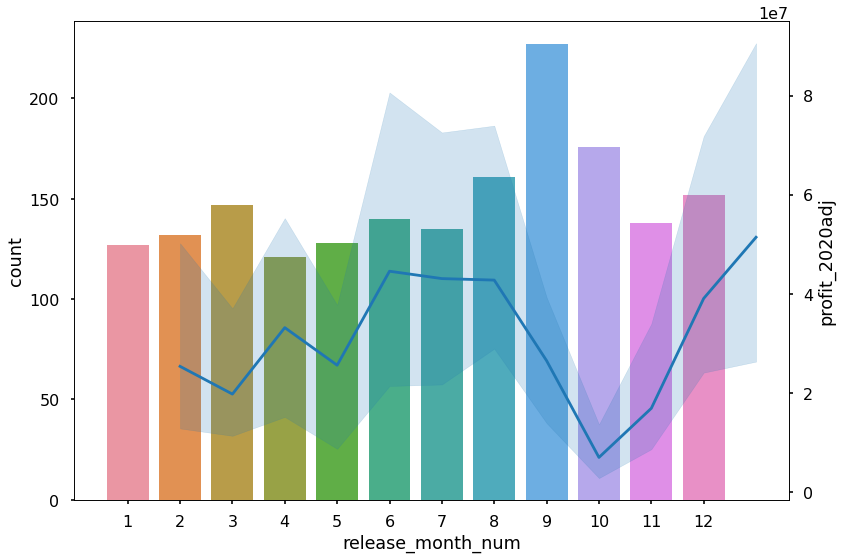

In [747]:
month_order = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']

with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()
    # source: https://stackoverflow.com/questions/57207245/
    #how-do-you-use-count-plot-and-line-plot-with-the-same-y-axis-in-seaborn
    ax2=ax.twinx()

    sns.countplot(x=df['release_month_num'], ax=ax)
    sns.lineplot(x=df['release_month_num'], y=df['profit_2020adj'], sort=True,
                 estimator=np.median, ax=ax2)
    
    #ax.plot(df.groupby('release_month')['profit_2020adj'].median());
    #ax.set_title('Count of Movies Released in each Calendar Month');
    #ax.set_xlabel('Release Month');
    #ax.set_ylabel('Number of Movies Released');

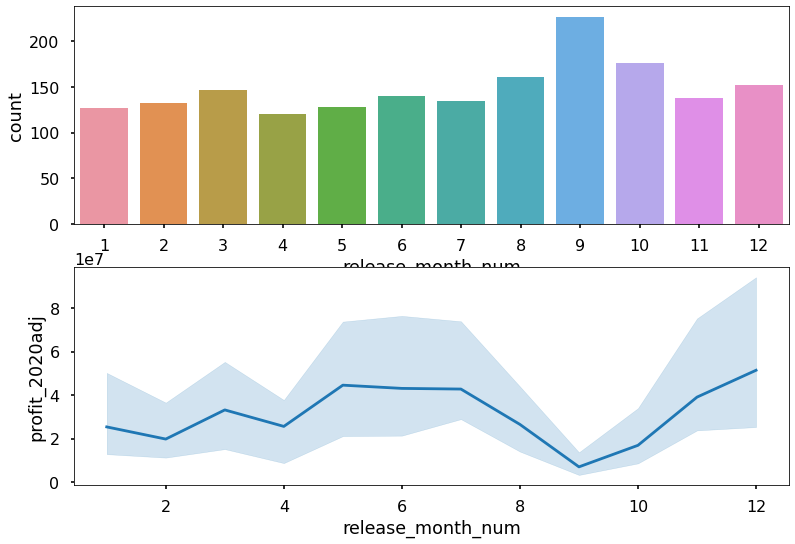

In [758]:
month_order = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']

with plt.style.context('seaborn-poster'):
    fig, ([ax1, ax2]) = plt.subplots(ncols=1, nrows=2)

    sns.countplot(x=df['release_month_num'], ax=ax1)
    sns.lineplot(x=df['release_month_num'], y=df['profit_2020adj'], sort=True,
                 estimator=np.median, ax=ax2)
    
    #ax.plot(df.groupby('release_month')['profit_2020adj'].median());
    #ax.set_title('Count of Movies Released in each Calendar Month');
    #ax.set_xlabel('Release Month');
    #ax.set_ylabel('Number of Movies Released');

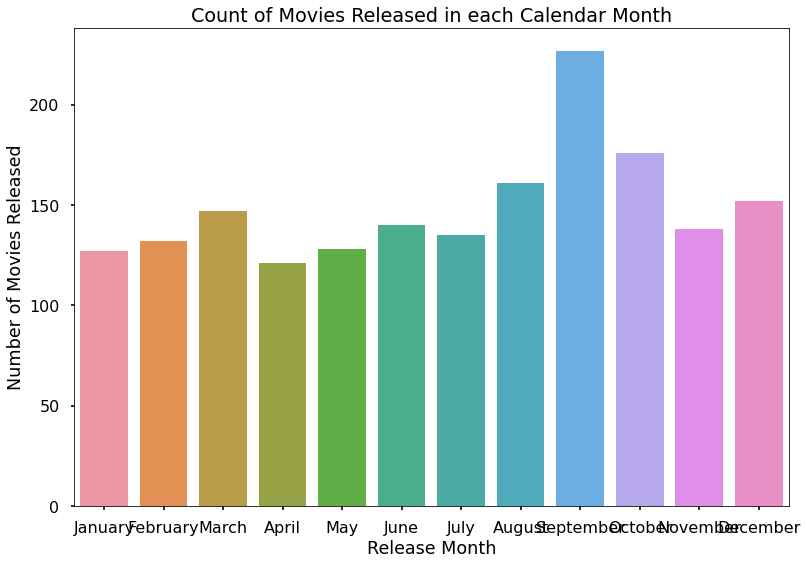

In [696]:
month_order = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']

with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()

    sns.countplot(x=df['release_month'], order=month_order)

    ax.set_title('Count of Movies Released in each Calendar Month');
    ax.set_xlabel('Release Month');
    ax.set_ylabel('Number of Movies Released');
